# Self-Attention GAN의 학습, 생성

In [1]:
# 패키지 import
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## Self-Attention 모듈 구현

In [2]:
class Self_Attention(nn.Module):
    """Self-Attention의 Layer"""

    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()

        # 1×1의 합성곱 층에 의한 pointwise convolution를 준비
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        # Attention Map 작성시의 규격화의 소프트맥스
        self.softmax = nn.Softmax(dim=-2)

        # 원래 입력 x와 Self-Attention Map인 o를 더할 때의 계수
        # output = x +gamma*o
        # 처음에는 gamma=0으로 학습시킨다
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        # 입력 변수
        X = x

        # 합성곱한 뒤, 크기를 변형시킨다. B,C',W,H→B,C',N으로
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # 크기: B,C',N
        proj_query = proj_query.permute(0, 2, 1)  # 전치 조작
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # 크기: B,C',N

        # 곱셈
        S = torch.bmm(proj_query, proj_key)  # bmm은 배치별 행렬곱입니다

        # 규격화
        attention_map_T = self.softmax(S)  # i행 방향의 합을 1로 하는 소프트맥스 함수
        attention_map = attention_map_T.permute(0, 2, 1)  # 전치한다

        # Self-Attention Map을 계산한다
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # 크기: B,C,N
        o = torch.bmm(proj_value, attention_map.permute(
            0, 2, 1))  # Attention Map을 전치하여 곱함

        # Self-Attention Map o의 텐서 크기를 X로 준비하여 출력으로 한다
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x+self.gamma*o

        return out, attention_map


## 생성기 Generator 구현

In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8,
                                                      kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 8, image_size * 4,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 4, image_size * 2,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        # Self-Attention층을 추가
        self.self_attntion1 = Self_Attention(in_dim=image_size * 2)

        self.layer4 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 2, image_size,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        # Self-Attention층을 추가
        self.self_attntion2 = Self_Attention(in_dim=image_size)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 주의: 흑백 화상이므로 출력 채널은 하나 뿐임


    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2


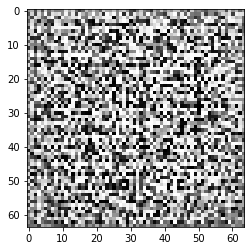

In [4]:
# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 난수 입력
input_z = torch.randn(1, 20)

# 텐서 크기를 (1, 20, 1, 1)으로 변형
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 가짜 화상을 출력
fake_images, attention_map1, attention_map2 = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


## 식별기 Discriminator 구현

In [5]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        # 주의: 흑백 화상이므로 출력 채널은 하나 뿐임

        self.layer2 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attention층을 추가
        self.self_attntion1 = Self_Attention(in_dim=image_size*4)

        self.layer4 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attention층을 추가
        self.self_attntion2 = Self_Attention(in_dim=image_size*8)

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2


In [6]:
# 동작 확인
D = Discriminator(z_dim=20, image_size=64)

# 가짜 화상 생성
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)

# 가짜 화상을 D에 입력
d_out, attention_map1, attention_map2 = D(fake_images)

# 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
print(nn.Sigmoid()(d_out))


tensor([[[[0.5001]]]], grad_fn=<SigmoidBackward>)


## 데이터 로더 작성

In [7]:
def make_datapath_list():
    train_img_list = list()

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_"+str(img_idx)+".jpg"
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_"+str(img_idx)+".jpg"

        train_img_list.append(img_path)
    
    return train_img_list

class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(img)

        return img_transformed

train_img_list = make_datapath_list()

mean = (0.5, )
std = (0.5, )

train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size())

torch.Size([64, 1, 64, 64])


## 네트워크 초기화와 학습 실시

In [8]:
# 모델을 학습시키는 함수를 작성
def train_model(G, D, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 오차함수 정의 → hinge version of the adversarial loss로 변경
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch의 손실합
        epoch_d_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # 데이터 로더에서 minibatch씩 꺼내는 루프
        for imges in dataloader:

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            # 미니 배치 크기가 1이면, 배치 노멀라이제이션에서 에러가 발생하므로 피한다
            if imges.size()[0] == 1:
                continue

            # GPU가 사용 가능하면 GPU로 데이터를 보낸다
            imges = imges.to(device)

            # 정답 라벨과 가짜 라벨 작성
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다
            mini_batch_size = imges.size()[0]
            #label_real = torch.full((mini_batch_size,), 1).to(device)
            #label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 진짜 화상을 판정
            d_out_real, _, _ = D(imges)

            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # 오차를 계산→hinge version of the adversarial loss로 변경
            # d_loss_real = criterion(d_out_real.view(-1), label_real)
            # d_loss_fake = criterion(d_out_fake.view(-1), label_fake)

            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            # 오차 d_out_real이 1이상에서 오차 0이 된다. d_out_real>1에서,
            # 1.0 - d_out_real가 음수이면 ReLU로 0으로 한다

            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            # 오차 d_out_fake가 -1 이하이면 오차 0이 된다. d_out_fake<-1에서,
            # 1.0 + d_out_real가 음수이면 ReLU로 0으로 한다

            d_loss = d_loss_real + d_loss_fake

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # 오차를 계산→hinge version of the adversarial loss로 변경
            #g_loss = criterion(d_out_fake.view(-1), label_real)
            g_loss = - d_out_fake.mean()

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # print("총 반복 횟수: ", iteration)

    return G, D


In [9]:
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)
D = Discriminator(z_dim=20, image_size=64)

G.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")



네트워크 초기화 완료


In [10]:
# 학습 및 검증을 실행한다
# 15분 정도 걸립니다
num_epochs = 300
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)


사용 장치:  cuda:0
-------------
Epoch 0/300
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.1456 ||Epoch_G_Loss:0.0143
timer:  0.8269 sec.
-------------
Epoch 1/300
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.1470 ||Epoch_G_Loss:0.0373
timer:  0.5274 sec.
-------------
Epoch 2/300
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.1196 ||Epoch_G_Loss:0.0099
timer:  0.5225 sec.
-------------
Epoch 3/300
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.0805 ||Epoch_G_Loss:0.0873
timer:  0.5313 sec.
-------------
Epoch 4/300
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.0935 ||Epoch_G_Loss:0.0506
timer:  0.5237 sec.
-------------
Epoch 5/300
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.0766 ||Epoch_G_Loss:0.0740
timer:  0.5238 sec.
-------------
Epoch 6/300
-------------
(train)
-------------
epoch 6 || Epoch_D_Loss:0.0927 ||Epoch_G_Loss:0.0643
timer:  0.5254 sec.
-------------
Epoch 7/300
-------------


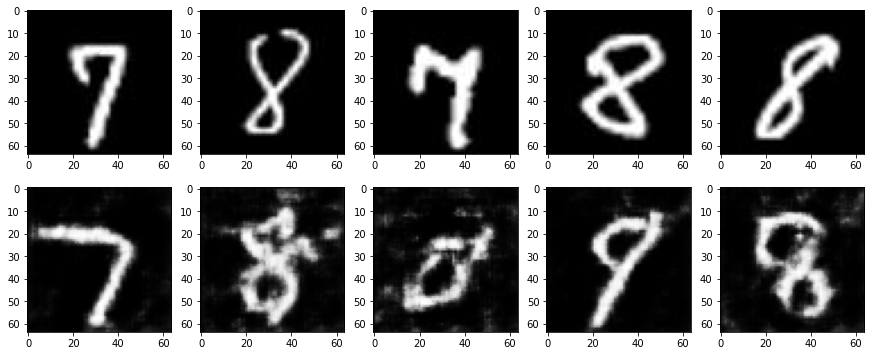

In [11]:
# 생성 화상과 훈련 데이터를 시각화한다
# 이 셀은 괜찮은 느낌의 화상이 생성될 때까지, 몇 번을 재실행하고 있습니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 화상 생성
G_update.eval()
fake_images, am1, am2 = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다


# 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')


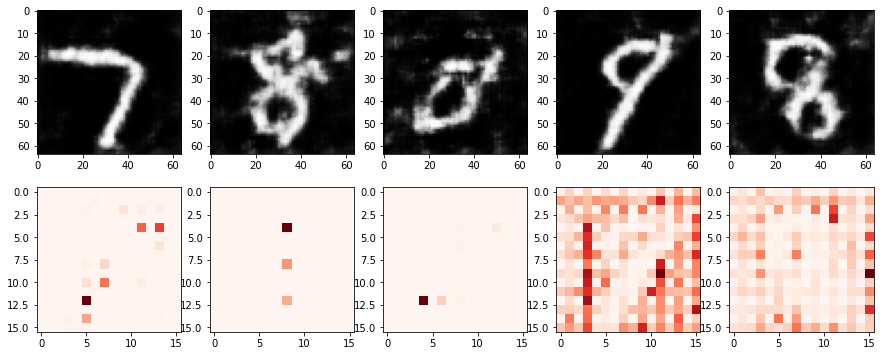

In [14]:
fig = plt.figure(figsize=(15,6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    am = am1[i].view(16,16,16,16)
    am = am[7][7]
    plt.imshow(am.cpu().detach().numpy(), "Reds")